In [59]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import ast
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv(r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\decode_sample_result.csv')

In [61]:
ART = df[df['mg_name'] == 'GE_ART'].reset_index(drop=True)
ART.loc[:,'binwave'] = ART['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

def statistical_ART(signal): 
    return {
        'mean'  :np.mean(signal),
        'std'   :np.std(signal),
        'max'   :np.max(signal),
        'min'   :np.min(signal),
        'range' :np.ptp(signal),
        'skewness':skew(signal),
        'kurtosis':kurtosis(signal),
        'variance':np.var(signal)
    }

ART_matrix = np.array([list(statistical_ART(row).values()) for row in ART['binwave']])
U, S, Vt = np.linalg.svd(ART_matrix, full_matrices=False)
print('Singular Values:', S)


Singular Values: [2.72547916e+06 6.51869409e+03 5.93300480e+02 2.68054609e+02
 5.76830155e+01 7.90109815e+00 4.49263652e-01 5.73106049e-12]


In [62]:
ECG = df[df['mg_name'] == 'GE_ECG'].reset_index(drop=True)
ECG.loc[:,'binwave'] = ECG['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

# Extract features from ECG signal using FFT
def featureExtraction_fft(signal, rate_hz):
    
    fft_transfer = fft(signal)
    magnitude = np.abs(fft_transfer)
    phase = np.angle(fft_transfer)

    freq_resolution = rate_hz / len(signal)

    low_freq_range = (0.5, 10)
    qrs_freq_range = (10, 50)
    high_freq_range = (50, rate_hz/2)

    low_freq_indices = np.floor(np.array(low_freq_range) / freq_resolution).astype(int)
    qrs_freq_indices = np.floor(np.array(qrs_freq_range) / freq_resolution).astype(int)
    high_freq_indices = np.floor(np.array(high_freq_range) / freq_resolution).astype(int)

    low_freq_power = np.sum(magnitude[low_freq_indices[0]:low_freq_indices[1]])
    qrs_freq_power = np.sum(magnitude[qrs_freq_indices[0]:qrs_freq_indices[1]])
    high_freq_power = np.sum(magnitude[high_freq_indices[0]:high_freq_indices[1]])
    peak_freq = np.argmax(magnitude[1:]) * freq_resolution  # Frequency with highest magnitude

    peaks, _ = find_peaks(magnitude)
    num_peaks = len(peaks)
    rate_hz = rate_hz

    return {
        'low_freq_power': low_freq_power,
        'qrs_freq_power': qrs_freq_power,
        'high_freq_power': high_freq_power,
        'peak_freq': peak_freq,
        'num_peaks': num_peaks,
        'mean_magnitude': np.mean(magnitude),
        'std_magnitude': np.std(magnitude),
        'mean_phase': np.mean(phase),
        'std_phase': np.std(phase),
        'skewness_magnitude': skew(magnitude),
        'kurtosis_magnitude': kurtosis(magnitude),
        'rate_hz':  rate_hz
    }


feature_names = ['low_freq_power', 'qrs_freq_power', 'high_freq_power', 'peak_freq', 'num_peaks', 
                 'mean_magnitude', 'std_magnitude', 'mean_phase', 'std_phase', 
                 'skewness_magnitude', 'kurtosis_magnitude','rate_hz']

fft_result = []

#extract features from each ECG signal
for i in range(len(ECG)):
    signal = ECG['binwave'][i]
    rate_hz = ECG['hz'][i]
    feature_result = featureExtraction_fft(signal, rate_hz)
    fft_result.append([feature_result[name] for name in feature_names])

#transform the result into a dataframe for visualization
ECG_df = pd.DataFrame(fft_result, columns=feature_names)

#drop the rate_hz column
ECG_matrix = np.array(fft_result)[:,:-1]

#tranform the matrix into a singular value decomposition for model training
U, S, Vt = np.linalg.svd(ECG_matrix, full_matrices=False)
print('Singular Values:', S)




Singular Values: [1.58660426e+06 7.34820121e+05 1.36456329e+05 2.34538036e+04
 1.35926601e+03 7.41792669e+02 2.17705371e+02 1.36434765e+02
 1.57793027e+01 1.39031110e+00 2.97851762e-01]


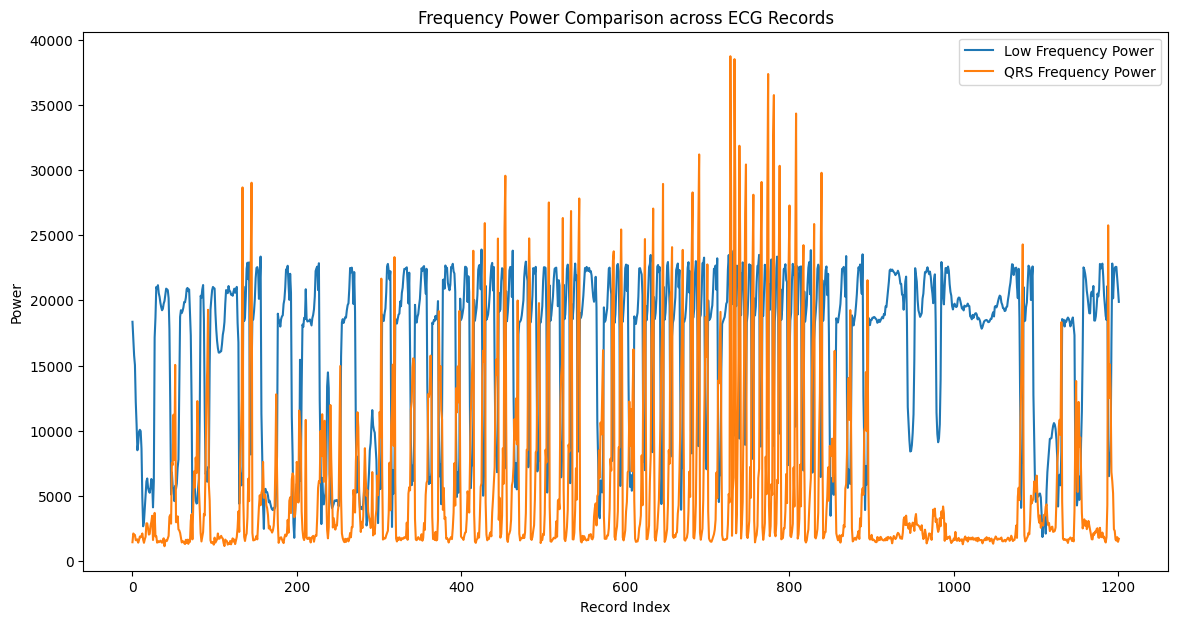

In [65]:
# Plot the frequency power comparison across ECG records

plt.figure(figsize=(14, 7))
plt.plot(ECG_df['low_freq_power'], label='Low Frequency Power')
plt.plot(ECG_df['qrs_freq_power'], label='QRS Frequency Power')
# plt.plot(ECG_df['high_freq_power'], label='High Frequency Power')
plt.title('Frequency Power Comparison across ECG Records')
plt.xlabel('Record Index')
plt.ylabel('Power')
plt.legend()
plt.show()


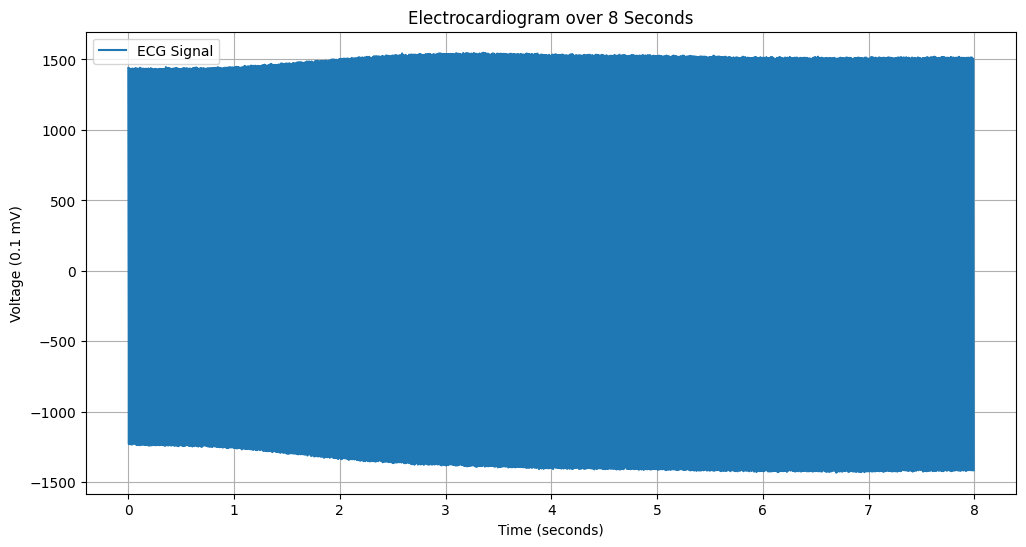

In [64]:
num_seconds = 8
sampling_rate = 180  

full_signal = np.concatenate(ECG['binwave'].iloc[0:num_seconds].values)


time_points = np.linspace(0, num_seconds, num_seconds * sampling_rate, endpoint=False)

plt.figure(figsize=(12, 6)) 
plt.plot(time_points, full_signal, label='ECG Signal')
plt.title('Electrocardiogram over 8 Seconds')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (0.1 mV)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
ECG['binwave']

0       [1439.0, -1229.0, 1436.0, -1229.0, 1432.0, -12...
1       [1442.0, -1256.0, 1446.0, -1258.0, 1448.0, -12...
2       [1503.0, -1331.0, 1505.0, -1336.0, 1502.0, -13...
3       [1539.0, -1381.0, 1539.0, -1376.0, 1539.0, -13...
4       [1528.0, -1399.0, 1535.0, -1406.0, 1531.0, -13...
                              ...                        
1197    [-1213.0, 1462.0, -1211.0, 1458.0, -1211.0, 14...
1198    [-1178.0, 1421.0, -1181.0, 1418.0, -1182.0, 14...
1199    [-1153.0, 1392.0, -1151.0, 1390.0, -1156.0, 13...
1200    [-1127.0, 1351.0, -1124.0, 1351.0, -1133.0, 13...
1201    [-1108.0, 1324.0, -1110.0, 1332.0, -1106.0, 13...
Name: binwave, Length: 1202, dtype: object

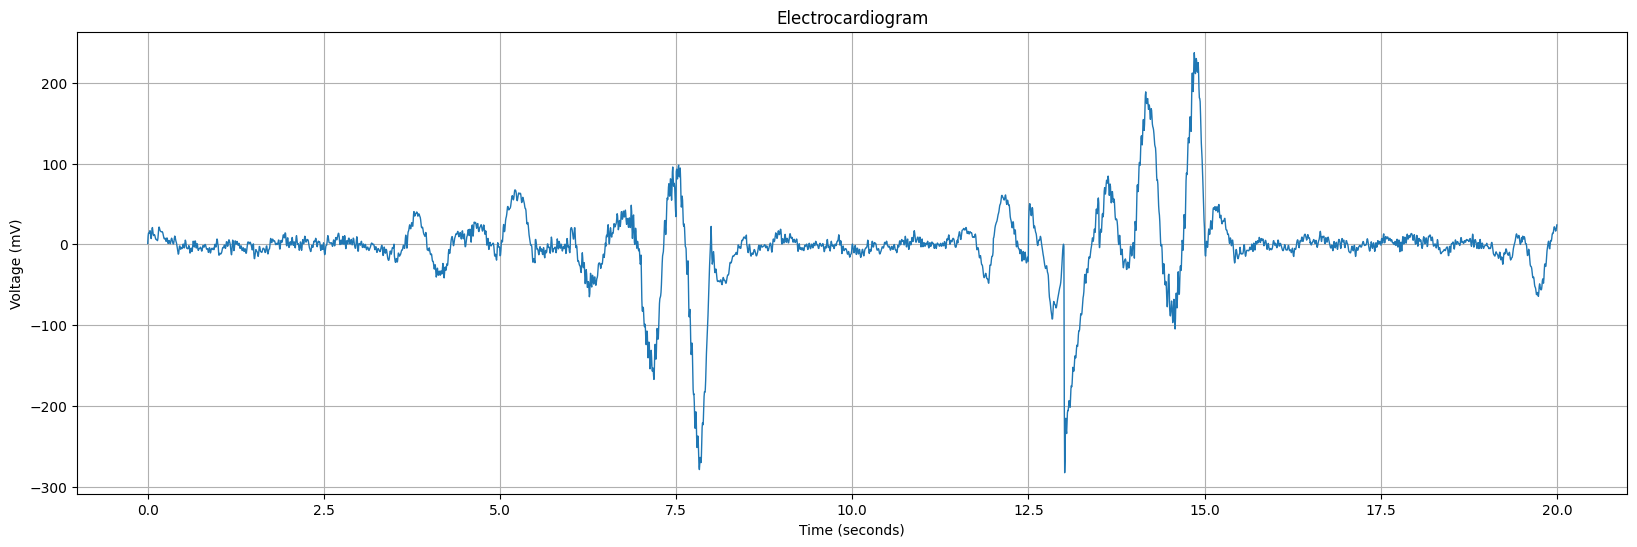

In [56]:
 # Use a bandpass filter to remove noise from the ECG signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def decode_differential_ecg(data):
    return np.array(data[::2]) - np.array(data[1::2])

def process_ecg(data_series, fs=180):
    processed_data = []
    for data_array in data_series:

        signal = decode_differential_ecg(data_array)
        
      
        filtered = butter_bandpass_filter(signal, lowcut=0.5, highcut=40, fs=fs)
        
        processed_data.extend(filtered)
    return np.array(processed_data)


ecg_data = ECG['binwave'].iloc[400:440]  


processed_ecg = process_ecg(ecg_data)


time = np.linspace(0, len(processed_ecg) / 180, len(processed_ecg))


plt.figure(figsize=(20, 6))
plt.plot(time, processed_ecg, linewidth=1)
plt.title('Electrocardiogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.show()

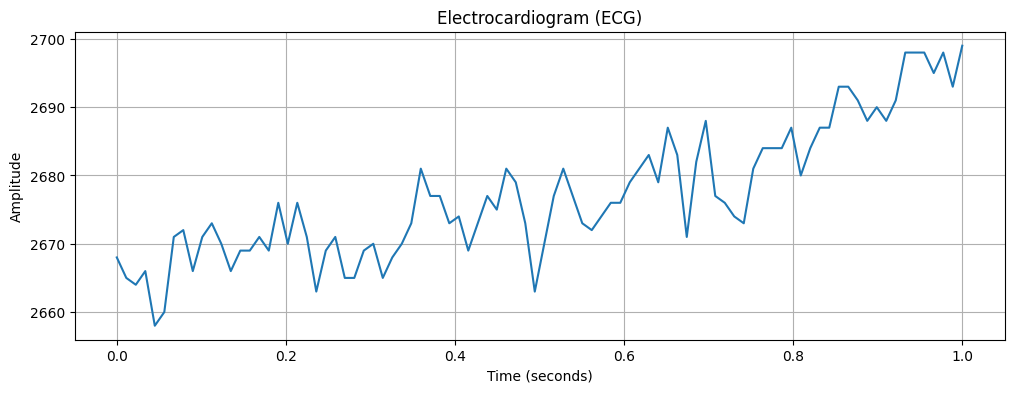

In [53]:
def decode_ecg(data):

    ecg_signal = np.array(data[::2]) - np.array(data[1::2])
    return ecg_signal


raw_data = ECG['binwave'][0]  

ecg_signal = decode_ecg(raw_data)


time = np.linspace(0, 1, len(ecg_signal))

plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal)
plt.title('Electrocardiogram (ECG)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()




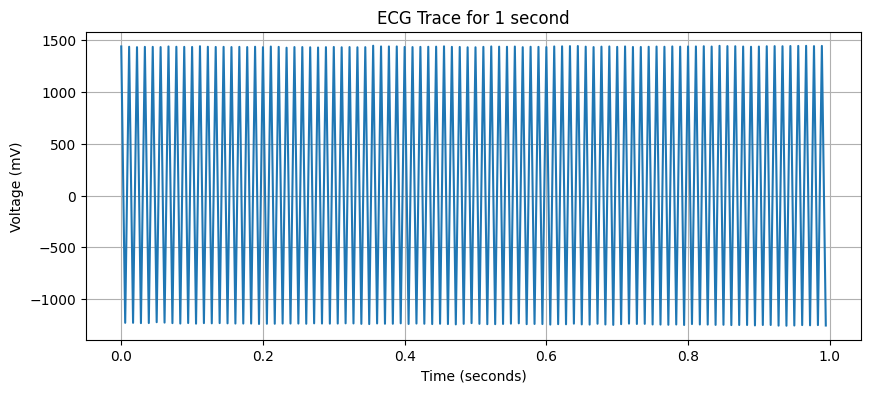

In [20]:
data = ECG['binwave'].iloc[0] 


n = len(data)
t = np.arange(0, n/180, 1/180)


plt.figure(figsize=(10, 4))
plt.plot(t, data)
plt.title('ECG Trace for 1 second')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.show()

In [35]:
df = ECG['binwave'][400:410].reset_index(drop=True)
df

0    [1247.0, -1049.0, 1257.0, -1051.0, 1256.0, -10...
1    [1273.0, -1080.0, 1273.0, -1085.0, 1268.0, -10...
2    [1290.0, -1088.0, 1289.0, -1076.0, 1290.0, -10...
3    [1301.0, -1098.0, 1293.0, -1088.0, 1299.0, -10...
4    [1316.0, -1109.0, 1323.0, -1108.0, 1319.0, -11...
5    [1363.0, -1136.0, 1363.0, -1131.0, 1359.0, -11...
6    [1422.0, -1191.0, 1423.0, -1188.0, 1430.0, -11...
7    [1495.0, -1249.0, 1494.0, -1249.0, 1496.0, -12...
8    [1582.0, -1362.0, 1585.0, -1364.0, 1577.0, -13...
9    [1770.0, -1554.0, 1764.0, -1557.0, 1775.0, -15...
Name: binwave, dtype: object

SyntaxError: invalid syntax (3970410081.py, line 11)